In [1]:
import sys
#sys.path.append('C:/Users/Fabian/Documents/gempy')
sys.path.insert(0, '/home/bl9/gempy')
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

import vtk
import evtk

from scipy.interpolate import griddata

import decision_making as dm

/home/bl9/gempy/gempy/plotting/visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')


In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,1000,0,1000,0,1000],[50,50,50],
                         path_o = ".././input_data/simple_dome_orientations1.csv",
                         path_i = ".././input_data/simple_dome_points1.csv")
geo_data.n_faults = 0

In [3]:
gp.set_series(geo_data, {"Dome":('Shale')},
                       order_series = ["Dome",], order_formations=['Shale',])

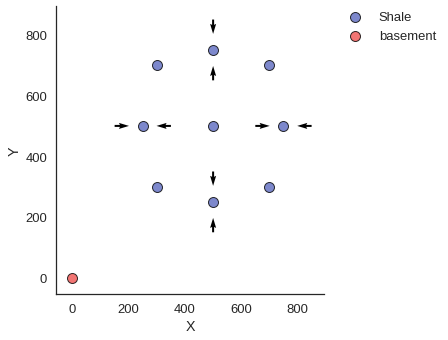

In [4]:
figsize(20,10)
gp.plotting.plot_data(geo_data,direction='z')

In [5]:
# Groups considering top view on spill line:
# From A to H clockwise, starting at center left
# Central points are a separate group (nan)

geo_data.interfaces['group_id']

0      A
1      G
2      C
3      E
4      H
5      B
6      F
7      D
8    NaN
9    NaN
Name: group_id, dtype: object

In [6]:
interp_data = gp.InterpolatorData(geo_data, 
                                   u_grade = [3], dtype ='float64')

In [7]:
lith_sol, fault_sol = gp.compute_model(interp_data)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0


In [8]:
base_n = int(geo_data.formations.loc['basement','formation_number'].values[0])
#sandstone_n = int(geo_data.formations.loc['Sandstone','formation_number'].values[0])
shale_n = int(geo_data.formations.loc['Shale','formation_number'].values[0])

In [9]:
#sst_surf_v, sst_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], n_formation = sandstone_n)
shale_surf_v, shale_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], n_formation = shale_n)

In [10]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

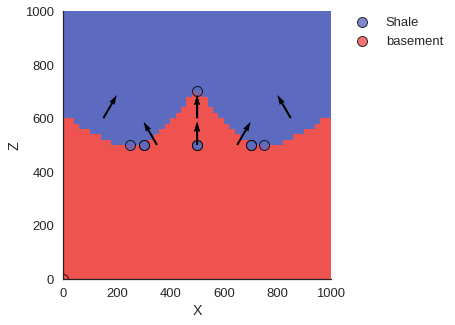

In [11]:
%matplotlib inline
figsize(20,10)
gp.plotting.plot_section(geo_data, lith_sol[0], int(resolution/2), plot_data=1, direction='y')

In [12]:
# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    
F_z_sst = interp_data.geo_data_res.interfaces.loc[0,'Z']
D_z_sst = interp_data.geo_data_res.interfaces.loc[1,'Z']
A_z_sst = interp_data.geo_data_res.interfaces.loc[2,'Z']
E_z_sst = interp_data.geo_data_res.interfaces.loc[5,'Z']
H_z_sst = interp_data.geo_data_res.interfaces.loc[6,'Z']
B_z_sst = interp_data.geo_data_res.interfaces.loc[7,'Z']

#A_z_shale = interp_data.geo_data_res.interfaces.loc[9,'Z']

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_unc = 50 #* unc_f

z_unc = pymc.Normal('z_unc', 0, 1./np.square(std_unc/rescale_f))

Variation by: 26.3165902815


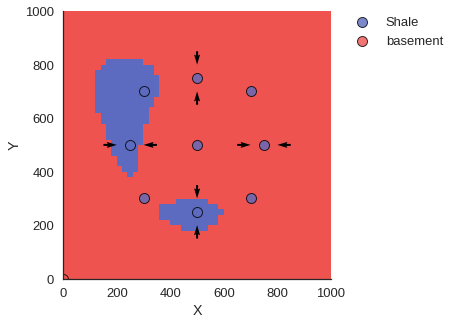

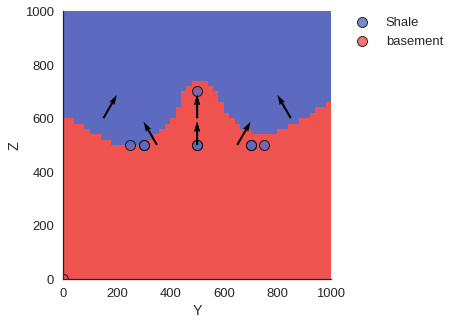

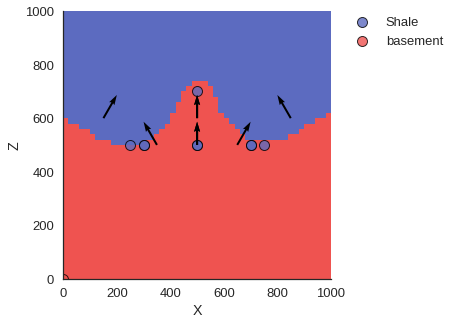

In [13]:
@pymc.deterministic
def interp_unc(value=0, z_unc=z_unc):
    
    print('Variation by:', z_unc*rescale_f)
    ###
    new_A_z_sst = A_z_sst + z_unc
    
    new_B_z_sst = B_z_sst + z_unc/2
    #new_C_z_sst = new_A_z_sst
    new_D_z_sst = D_z_sst + (z_unc/2)*(-1)
    new_E_z_sst = D_z_sst + z_unc*(-1)
    new_F_z_sst = F_z_sst + (z_unc/2)*(-1)
    #new_G_z_sst = new_A_z_sst
    new_H_z_sst = H_z_sst + z_unc/2
    
    ###
    interp_data.geo_data_res.interfaces.loc[0,'Z'] = new_F_z_sst
    interp_data.geo_data_res.interfaces.loc[1,'Z'] = new_D_z_sst
    interp_data.geo_data_res.interfaces.loc[2,'Z'] = new_A_z_sst
    #interp_data.geo_data_res.interfaces.loc[3,'Z'] = new_G_z_sst
    #interp_data.geo_data_res.interfaces.loc[4,'Z'] = new_C_z_sst
    interp_data.geo_data_res.interfaces.loc[5,'Z'] = new_E_z_sst
    interp_data.geo_data_res.interfaces.loc[6,'Z'] = new_H_z_sst
    interp_data.geo_data_res.interfaces.loc[7,'Z'] = new_B_z_sst
   
    return interp_data

@pymc.deterministic
def structural_model(interp_data_M=interp_unc, shale_n=shale_n, print_figures=True):
    lith_sol, fault_sol = gp.compute_model(interp_data_M)
    lith_block = lith_sol[0]
    #fault_block = fault_sol[0]  
    #shale_surf_v, shale_surf_s = gp.get_surfaces(\
    #    interp_data = interp_data_M, potential_lith=lith_sol[1], 
    #    potential_fault=fault_sol[1], n_formation = shale_n)
    #max_vol, trap, SSF, trap_control = max_trap_vol(interp_data_M, lith_block, fault_block, seal_surf_v, seal_th)
    #print("Maximum trap volume: %s m³" % max_vol)
    if print_figures:
        plt.figure(1)
        gp.plotting.plot_section(geo_data, lith_sol[0], 
                                 int(resolution/2), plot_data =1, direction='z')
        plt.figure(2)
        gp.plotting.plot_section(geo_data, lith_sol[0], 
                                 int(resolution/2), plot_data =1, direction='x')
        plt.figure(3)
        gp.plotting.plot_section(geo_data, lith_sol[0], 
                                 int(resolution/2), plot_data =1, direction='y')
        #gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
    return lith_sol#, fault_sol, max_vol, trap, SSF, trap_control


In [14]:
iterations = 20
model = pymc.Model([interp_unc, z_unc, structural_model])

Variation by: 54.2476574613
 [---              10%                  ] 2 of 20 complete in 3.0 secVariation by: -54.8169410234
 [-----            15%                  ] 3 of 20 complete in 6.3 secVariation by: -5.77018183622
 [-------          20%                  ] 4 of 20 complete in 9.5 secVariation by: -119.395946916
 [---------        25%                  ] 5 of 20 complete in 12.6 secVariation by: 19.4085469747
 [-----------      30%                  ] 6 of 20 complete in 15.7 secVariation by: 16.6476278585
 [-------------    35%                  ] 7 of 20 complete in 18.8 secVariation by: -2.35523738875


/home/bl9/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 [---------------  40%                  ] 8 of 20 complete in 22.0 secVariation by: 63.320346212
 [-----------------45%                  ] 9 of 20 complete in 25.1 secVariation by: -30.1653042347
 [-----------------50%                  ] 10 of 20 complete in 28.7 secVariation by: 66.3110975537
 [-----------------55%                  ] 11 of 20 complete in 31.7 secVariation by: -12.9284579047
 [-----------------60%--                ] 12 of 20 complete in 34.9 secVariation by: 79.2139111218
 [-----------------65%----              ] 13 of 20 complete in 38.2 secVariation by: 55.0308338933
 [-----------------70%------            ] 14 of 20 complete in 41.7 secVariation by: -118.213142027
 [-----------------75%--------          ] 15 of 20 complete in 44.8 secVariation by: 21.012148262
 [-----------------80%----------        ] 16 of 20 complete in 47.8 secVariation by: 7.50661455146
 [-----------------85%------------      ] 17 of 20 complete in 50.8 secVariation by: -21.9431510133
 [--------

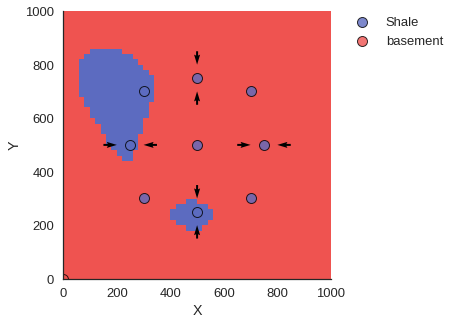

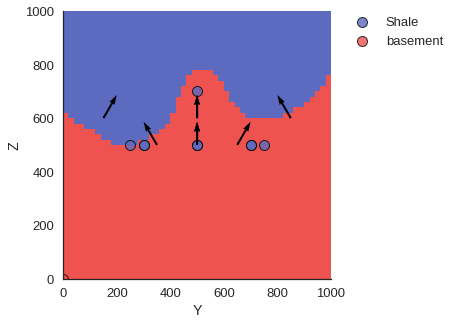

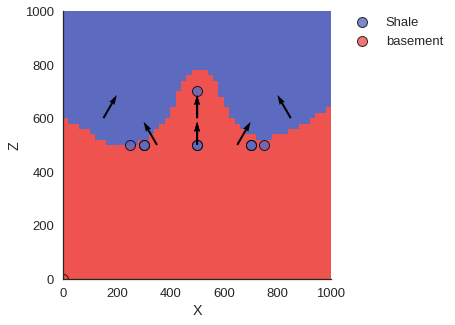

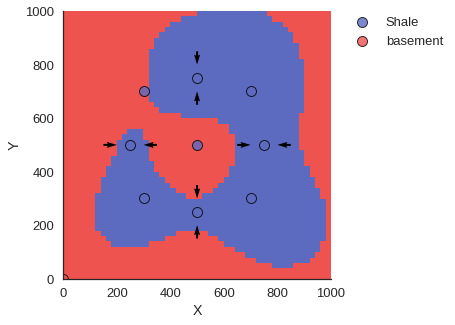

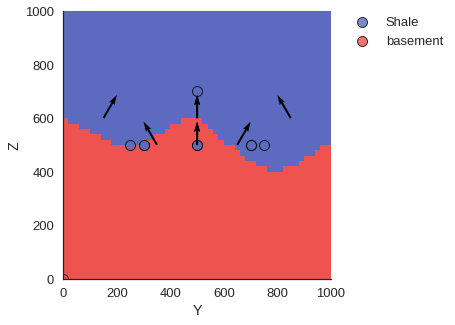

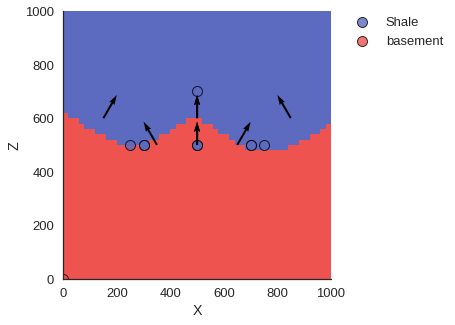

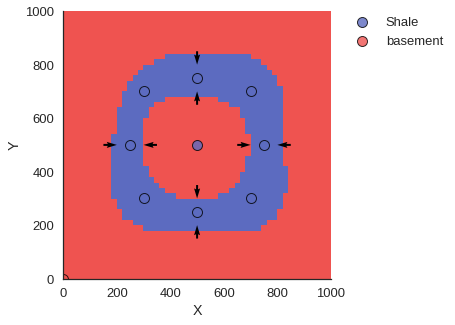

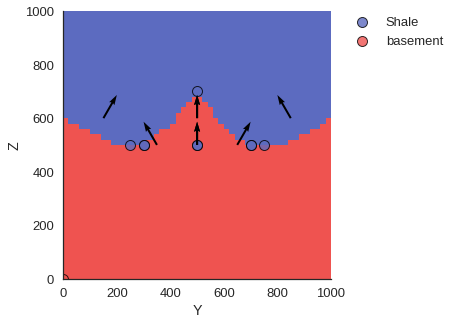

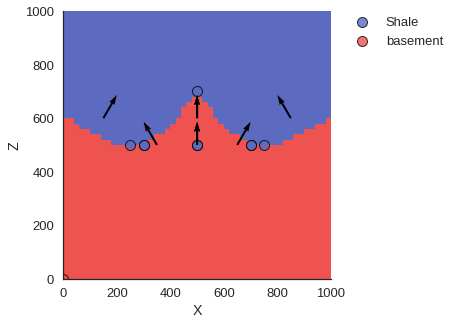

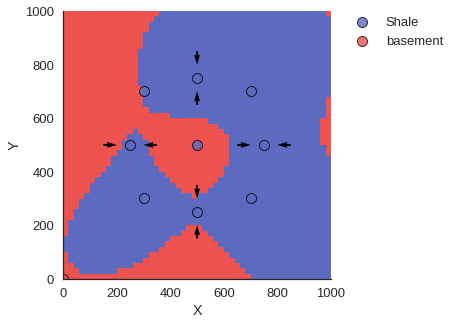

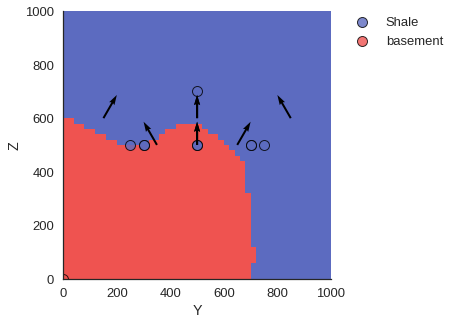

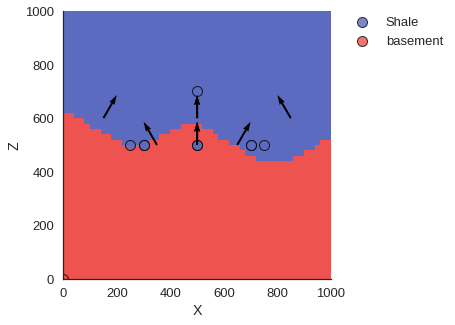

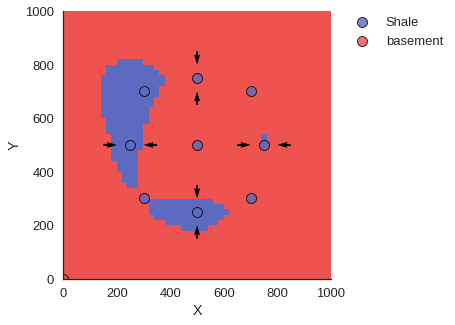

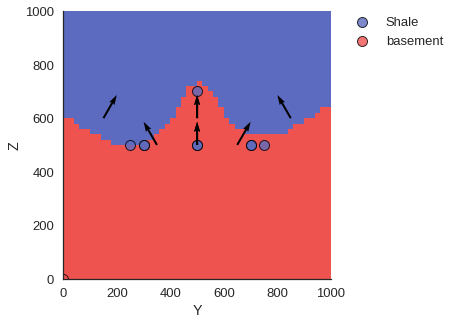

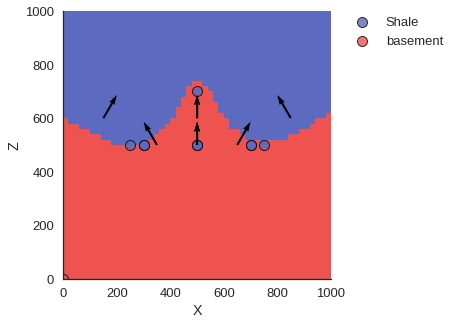

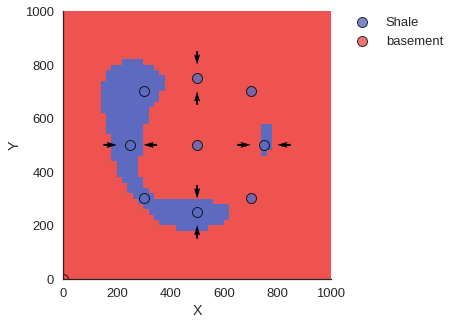

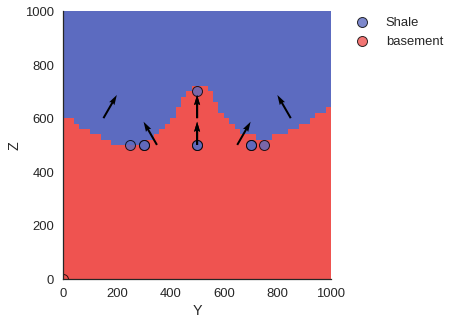

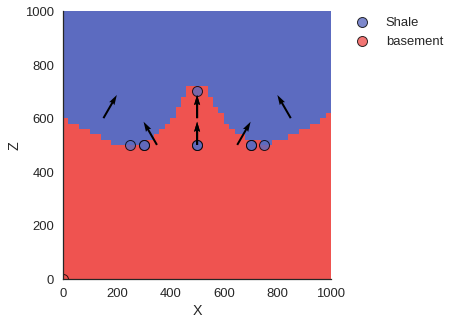

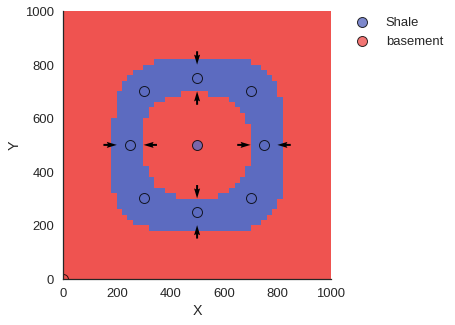

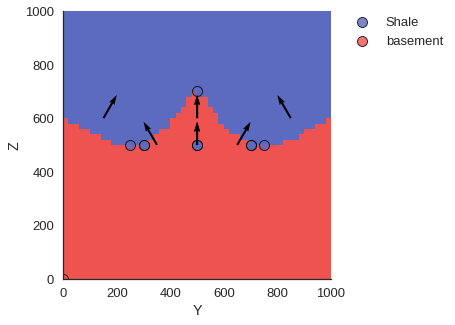

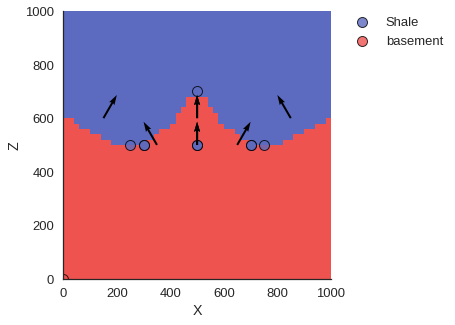

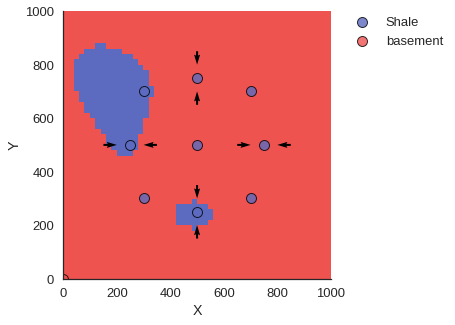

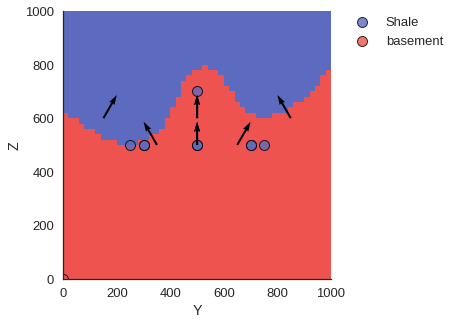

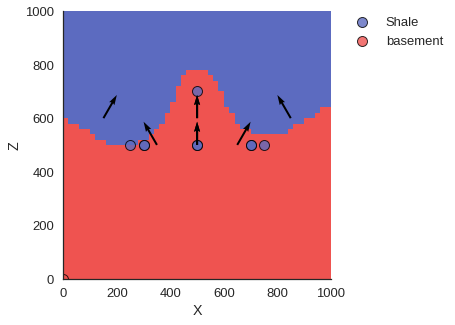

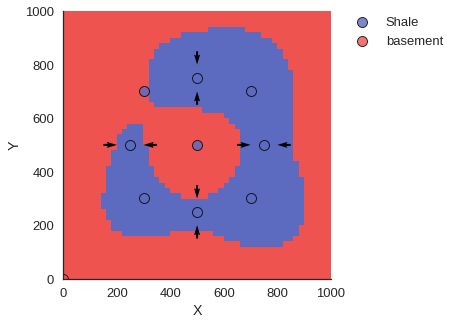

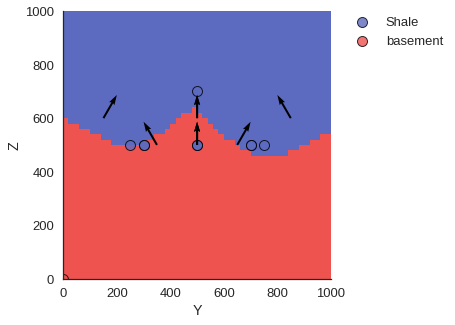

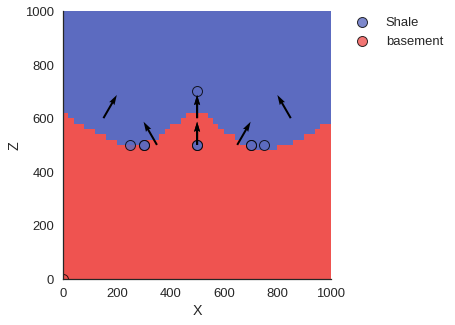

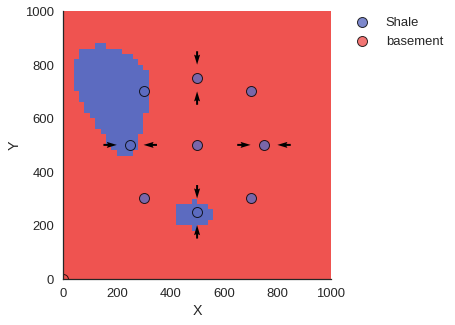

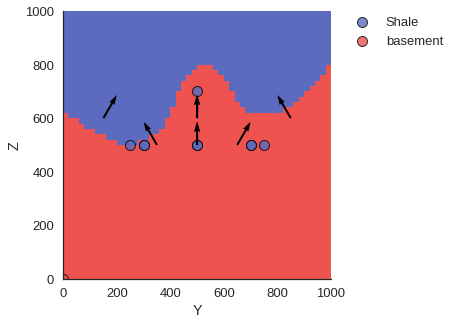

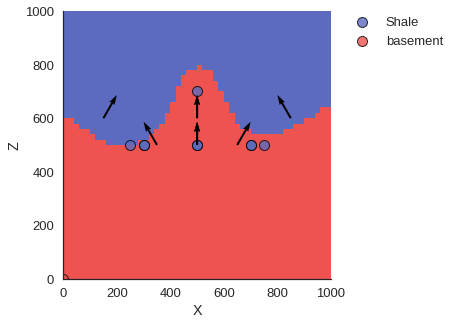

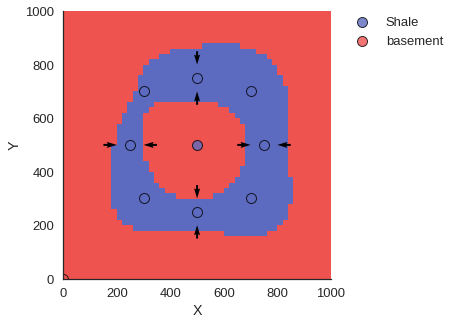

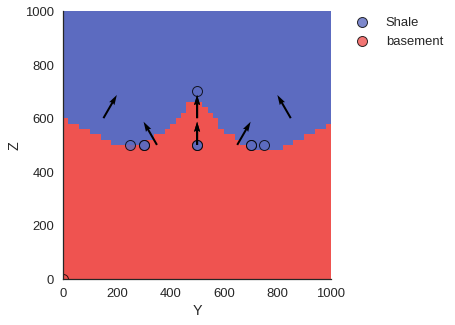

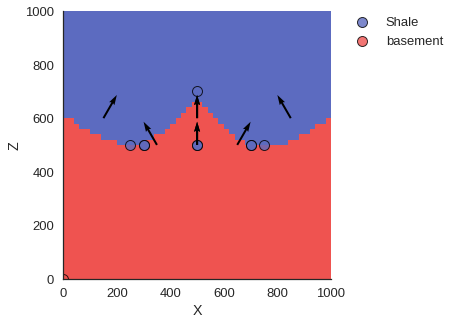

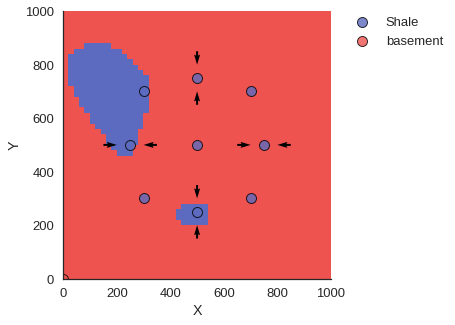

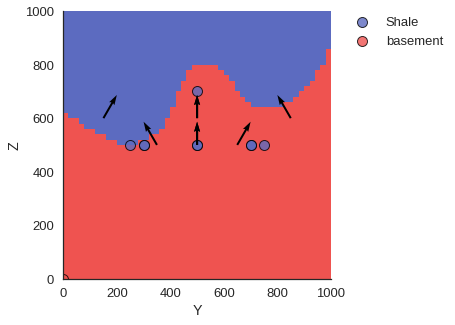

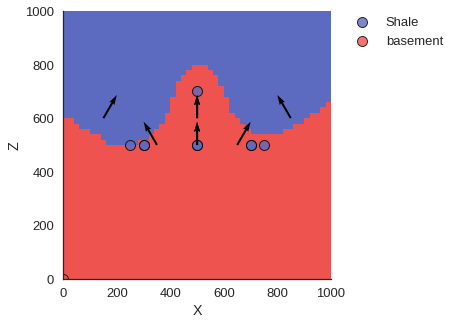

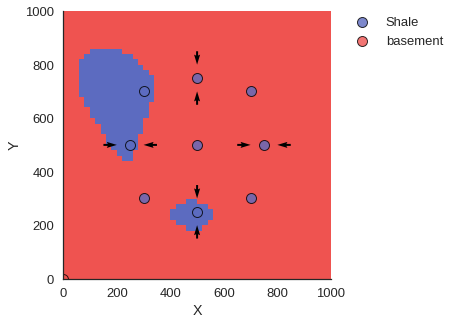

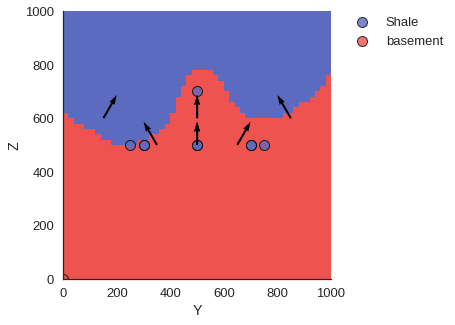

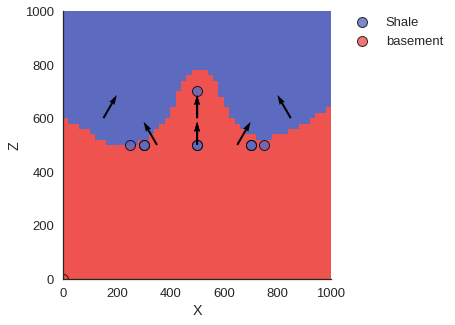

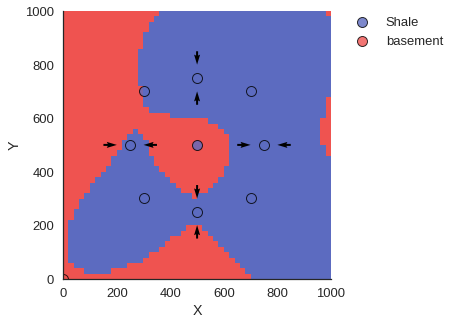

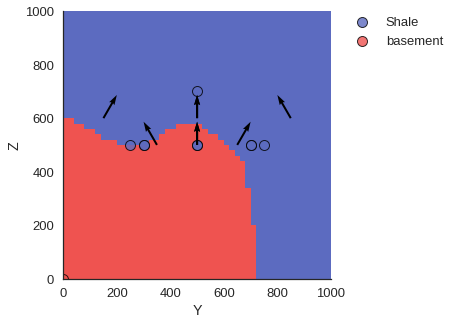

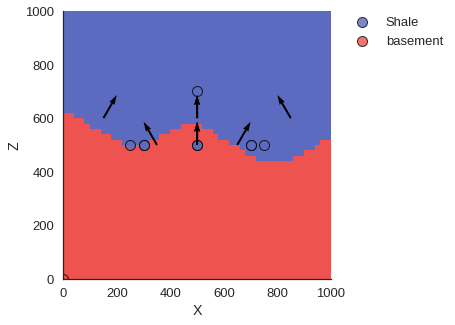

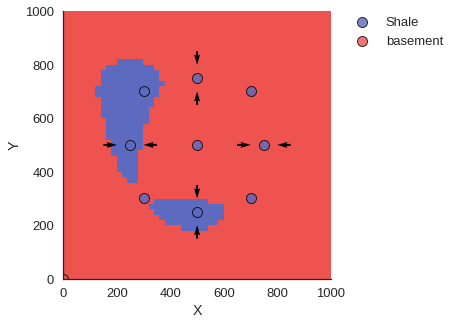

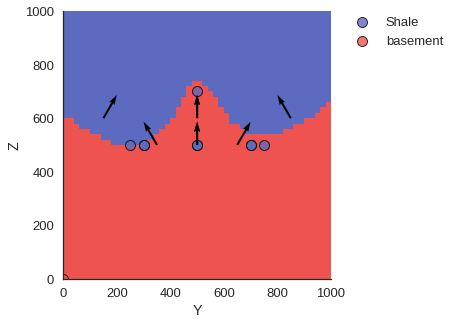

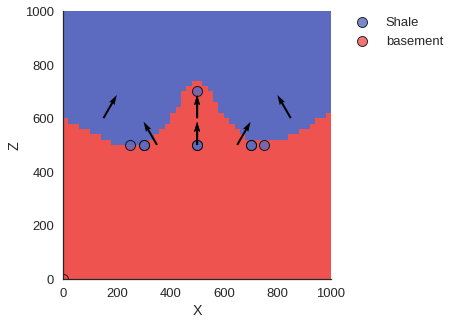

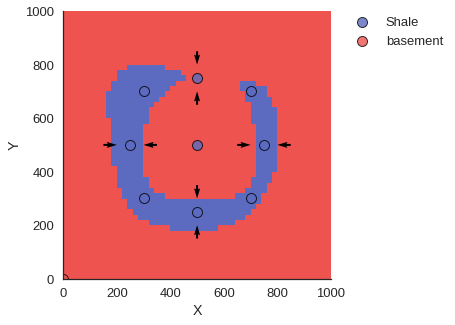

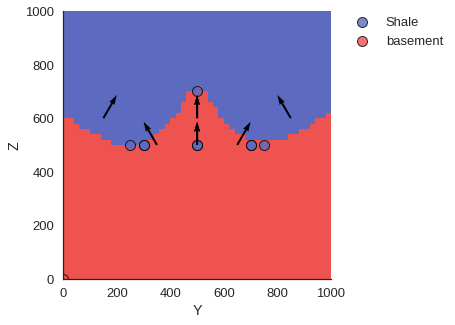

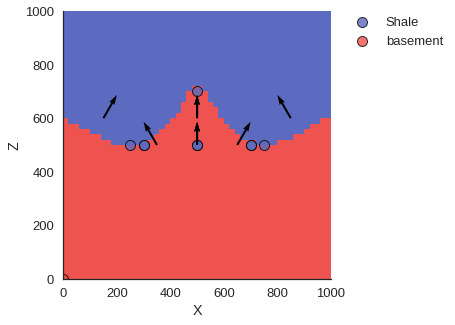

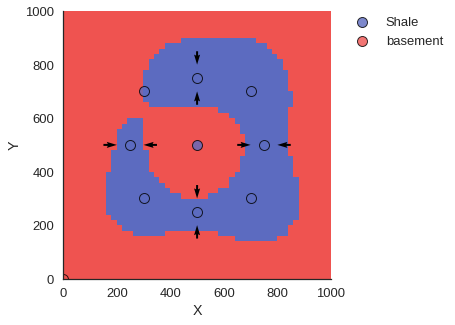

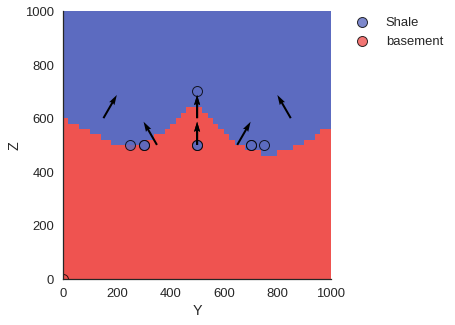

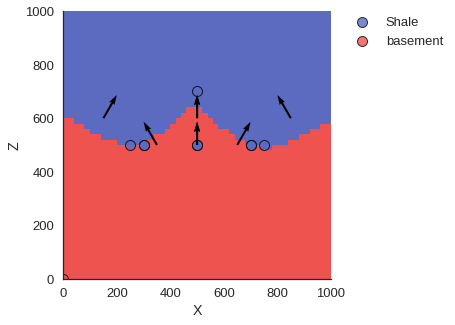

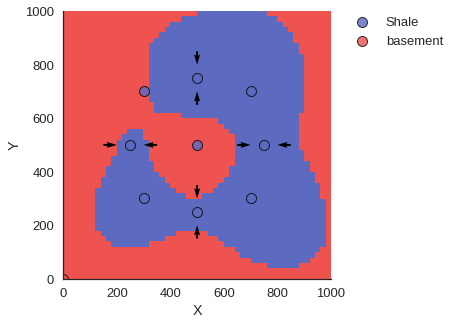

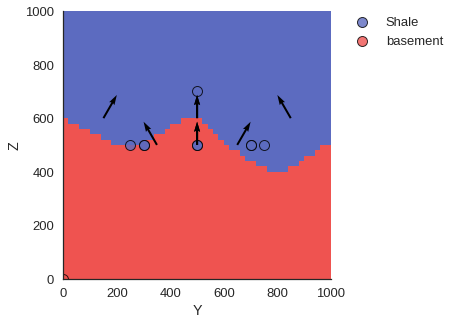

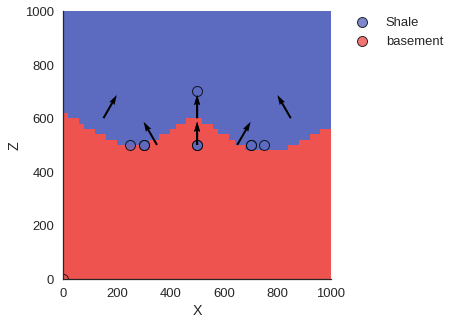

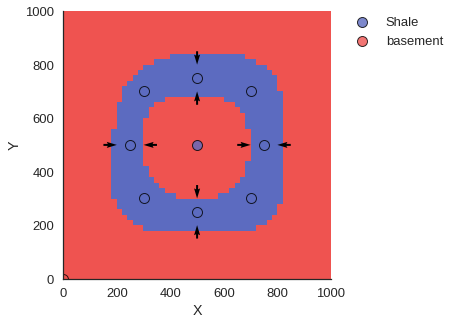

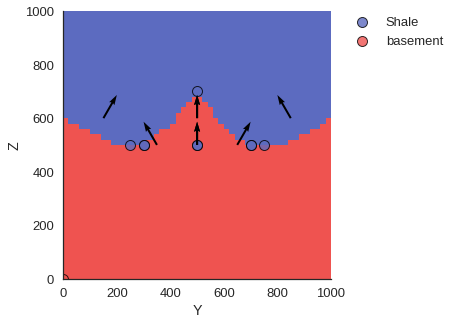

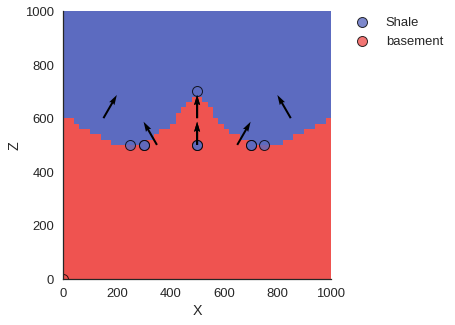

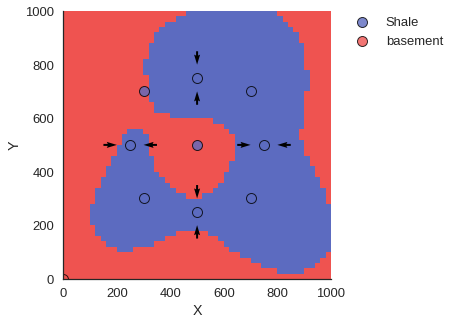

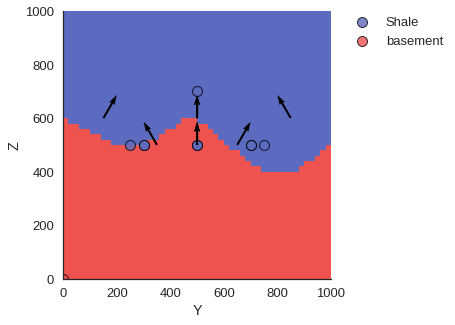

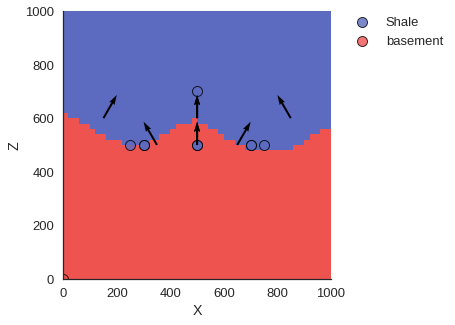

In [15]:
M = pymc.MCMC(model)
#M = pymc.MCMC(model,db= "hdf5" , dbname= "D:/PyMC_DataBase/prior_model_noBlocks_SSFc_3_1000iter_2017_11_12")
M.sample(iter=iterations)